In [1]:
import yfinance as yf
import pandas as pd

import warnings
import quantstats as qs
warnings.filterwarnings("ignore")
son=pd.read_excel("C:/Users/Bora/Documents/GitHub/AI_Trade/excel/FiyatPenceresi.xlsx")
hisseler=son["Kod"].values

result1=pd.read_csv("all_data.csv",index_col=0)
result1.index=pd.to_datetime(result1.index)
result1


,High,Low,Open,Adj Close,Volume,Hisse,Son,Önceki,Index,Yüksek,...,14_High,14_Low,Stoch %K,Stoch %D,Stochastic_K_D_Distance,Return,Return Lag,Index Return,Beta,Date.1
Date,,,,,,,,,,,,,,,,,,,,,
2021-03-28,6.28,5.00,5.50,6.12,21525087,ICBCT,6.13,6.05,-8.733705,6.36,...,7.73,4.29,53.197674,55.243774,-3.703765,-0.980392,1.322314,-0.087337,0.110397,2021-03-28
2021-03-28,1.84,1.53,1.72,1.77,181835913,TEKTU,1.78,1.73,-8.733705,1.94,...,12.08,1.53,2.274882,1.136516,100.162756,3.954802,2.890173,-0.087337,-0.135982,2021-03-28
2021-03-28,0.55,0.46,0.52,0.53,38197704,KUYAS,0.53,0.52,-8.733705,0.59,...,85.40,0.46,0.082411,0.070664,16.624688,9.433962,1.923077,-0.087337,0.094308,2021-03-28
2021-03-28,8.71,7.45,8.67,8.30,589895507,ENJSA,8.28,8.54,-8.733705,9.26,...,291.75,7.45,0.298980,0.307993,-2.926481,11.084337,-3.044496,-0.087337,0.146111,2021-03-28
2021-03-28,16.00,13.56,15.20,14.51,51119798,BTCIM,14.25,14.82,-8.733705,17.55,...,18.65,4.62,70.491803,80.874317,-12.837838,17.160579,-3.846154,-0.087337,-0.000271,2021-03-28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-22,10.42,9.41,10.38,9.42,111221051,ORCAY,9.46,9.51,-3.239980,4.71,...,10.95,8.36,40.926641,63.054063,-35.092778,0.000000,-0.525762,-0.032400,0.343673,2024-12-22
2024-12-22,32.08,29.04,31.22,29.28,78771822,AYEN,29.32,29.68,-3.239980,13.68,...,32.08,24.46,63.254593,72.407616,-12.640967,0.000000,-1.212938,-0.032400,0.062405,2024-12-22
2024-12-22,180.30,162.30,178.60,164.20,171708757,AYGAZ,169.20,164.00,-3.239980,13.83,...,184.90,140.00,53.897550,77.337349,-30.308511,0.000000,3.170732,-0.032400,-0.138723,2024-12-22


# Model Optimizasyonu ve Kurulumu

### Optimizasyon yaparken uyguladığım strateji veriyi 3 parçaya bölmek.İlk parçada train,2.parçada sharpe metriğe göre optimizasyon ve son aşamada optimize edilen zaman aralığında en iyi modellere bakarken hiç optimizasyona uğramamış test bölgesinde de en iyi performansı gösteren modelleri seçmektir.Böylece optimizasyon sonrasında da iyi performans gösterdiğinden emin olmak istiyoruz.

### Burda 2021-2023 arası train seti,2023 yılı validation seti ve 2024 yılı test seti olarak seçtim.



In [10]:
import optuna
import tensorflow as tf
import random
import itertools
from lightgbm import LGBMRegressor
from sklearn.model_selection import TimeSeriesSplit
from catboost import CatBoostRegressor
import quantstats as qs
from sklearn.model_selection import train_test_split
from lightgbm import early_stopping, log_evaluation
import joblib
features = ['Volume',
       'Distance_20_MA', 'Distance_200_MA', 'Volume_Distance', 'RSI', 'TR', 'ATR', 'Normalized_RSI', 'avg_ATR',
       'ATR_Percentage', 'Pivot_Distance', 'Support_Distance',
       'Resistance_Distance', 'Distance_5_MA',
       'Distance_10_MA', '1D_ROC', '3D_RSI',
       'Volume_Increase_Rate',
       'Bollinger_Band_Position', 'Daily_High_Low_Position', 'Distance_5D_High', 'Distance_5D_Low', '5D_Vol_MA',
       '20D_Vol_MA', 'Volume_Oscillator', 'MACD_Line',
       'Signal_Line', 'MACD_Distance', 'VWAP', 'VWAP_Distance',
        'Stoch %K', 'Stoch %D', 'Stochastic_K_D_Distance','Beta']


result1=result1.sort_index()
train=result1.loc[:"2022-12-31"]
val=result1.loc["2023-01-01":"2023-12-12"]






def objective(trial):
    features = ['Volume',
       'Distance_20_MA', 'Distance_200_MA', 'Volume_Distance', 'RSI', 'TR', 'ATR', 'Normalized_RSI', 'avg_ATR',
       'ATR_Percentage', 'Pivot_Distance', 'Support_Distance',
       'Resistance_Distance', 'Distance_5_MA',
       'Distance_10_MA', '1D_ROC', '3D_RSI',
       'Volume_Increase_Rate',
       'Bollinger_Band_Position', 'Daily_High_Low_Position', 'Distance_5D_High', 'Distance_5D_Low', '5D_Vol_MA',
       '20D_Vol_MA', 'Volume_Oscillator', 'MACD_Line',
       'Signal_Line', 'MACD_Distance', 'VWAP', 'VWAP_Distance',
        'Stoch %K', 'Stoch %D', 'Stochastic_K_D_Distance','Beta']
    selected_features=[]
    for feature in features:
        if trial.suggest_categorical(feature, (True, False)):
            selected_features.append(feature)

    
    
    
    

    X_train,X_val=train[selected_features],val[selected_features]
    hisseler=val["Hisse"]
    y_train,y_val=train["Return"],val["Return"]

    params = {
    'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
    'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
    'max_depth': trial.suggest_int('max_depth', 3, 15),
    'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10),  # L1 regularization
    'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10),  # L2 regularization
    'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
    'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
    'random_state': 42,
    'objective': 'regression',
    'metric': 'rmse',
    'verbosity': -1
}

    # CatBoostRegressor modeli
    model = LGBMRegressor(**params)
    model.fit(X_train, y_train)
    y_pred_val = model.predict(X_val)


    

    

    





    
    import quantstats as qs
    import warnings
    warnings.filterwarnings("ignore")


    



    tahminler=pd.DataFrame(model.predict(X_val))
    tahminler=tahminler.set_index(X_val.index)
    tahminler.columns=["Tahmin"]
    tahminler["Gerçek"]=val["Return"]
    tahminler["Hisse"]=val["Hisse"]
    tahminler["Return Lag"]=val["Return Lag"]
    tahminler["Alış Fiyat"]=val["Adj Close"]
    tahminler["Satış Fiyat"]=val["Satış Fiyat"]
    tahminler["Yüksek"]=val["Yüksek"]
    tahminler["Düşük"]=val["Düşük"]
    tahminler["Açılış"]=val["Açılış"]
    tahminler["KarAl"]=np.round(val["ATR"]+tahminler["Alış Fiyat"],2)
    tahminler_reset = tahminler.reset_index()


    tahminler_reset.loc[tahminler_reset["Yüksek"] >= tahminler_reset["KarAl"], "Satış Fiyat"] = tahminler_reset["KarAl"]
    tahminler_reset.loc[tahminler_reset["Açılış"] >= tahminler_reset["KarAl"], "Satış Fiyat"] = tahminler_reset["Açılış"]

    tahminler_reset = tahminler_reset[tahminler_reset["Return Lag"] < 9]
    tahminler_reset["Gerçek"]=((tahminler_reset["Satış Fiyat"]/tahminler_reset["Alış Fiyat"])-1)*100

    top_5_rows = tahminler_reset.groupby("Date").apply(lambda x: x.nlargest(5, columns=['Tahmin'])).dropna()
    top_5_rows=top_5_rows.droplevel(level=0)




    returns = top_5_rows.groupby('Date')["Gerçek"].mean()
    top_5_rows=top_5_rows.set_index("Date")


    bakiye=[100000]
    indexs=[]
    for date in top_5_rows.index.unique()[:-1]:
        df=top_5_rows.loc[date]
        if len(df)<1:
            pass
        else:
            indexs.append(df.index.unique())
            df["Para"]=bakiye[-1]/len(df)
            df["Lot"]=df["Para"]//(df["Alış Fiyat"]*1.1)

            df["Alış Hacim"]=df["Lot"]*df["Alış Fiyat"]
            df["Satış Hacim"]=df["Lot"]*df["Satış Fiyat"]
            komisyon=(df["Alış Hacim"]*0.0004)+(df["Alış Hacim"]*0.0004*0.000025)+(df["Alış Hacim"]*0.0004*0.05)+(df["Satış Hacim"]*0.0004)+(df["Satış Hacim"]*0.0004*0.000025)+(df["Satış Hacim"]*0.0004*0.05)
            df["Kar"]=df["Lot"]*(df["Satış Fiyat"]-df["Alış Fiyat"])
            df["Kar"]=df["Kar"]-komisyon
            kar=df["Kar"].sum()
            bakiye.append(bakiye[-1]+kar)

    index_list = [idx[0] for idx in indexs]

    # Listeyi tek bir DatetimeIndex'e çevir
    merged_index = pd.DatetimeIndex(index_list, name='Date')
    bakiye=pd.DataFrame(bakiye[1:])
    bakiye=bakiye.set_index(merged_index)
    backtest=((bakiye/100000)-1)*100


    backtest=backtest.sort_index()
    sharpe=qs.stats.sharpe(bakiye[0].pct_change())








    joblib.dump(model, f"weekly/model_{sharpe}.pkl")
    print("Combined Custom Loss:", sharpe)

    return sharpe

   



"""study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=500)

# Print the best hyperparameters
print('Best hyperparameters:', study.best_params)"""


"study = optuna.create_study(direction='maximize')\nstudy.optimize(objective, n_trials=500)\n\n# Print the best hyperparameters\nprint('Best hyperparameters:', study.best_params)"

In [7]:
def kademe(fiyat):
    if 0.01 <= fiyat <= 19.99:
        return 0.01
    elif 20 <= fiyat <= 49.99:
        return 0.02
    elif 50 <= fiyat <= 99.99:
        return 0.05
    elif 100 <= fiyat <= 249.99:
        return 0.10
    elif 250 <= fiyat <= 499.99:
        return 0.25
    elif 500 <= fiyat <= 999.99:
        return 0.50
    elif 1000 <= fiyat <= 2499.99:
        return 1.00
    elif fiyat >= 2500:
        return 2.50
    else:
        return None



In [8]:
dosya_yolu = "D:/iDeal/data/IMKBX'XU100_60.txt"
 
df = pd.read_csv(
            dosya_yolu,
            delimiter=';',   # Noktalı virgül ile ayrıldığını varsayıyoruz
            decimal=',',     # Ondalık ayırıcı olarak virgül kullanılıyor
            header=None,     # Eğer sütun başlıkları yoksa
            names=['Tarih', 'Saat', 'Açılış', 'Yüksek', 'Düşük', 'Kapanış', 'Hacim']  # Sütun isimleri
        )
        



df['Datetime'] = pd.to_datetime(df['Tarih'], format='%d.%m.%Y')

# Datetime sütununu indeks olarak ayarla ve eski sütunları düşür
df=df.set_index('Datetime')
df=df[df["Saat"]=="18:00"]
df=df.drop(['Tarih', 'Saat'], axis=1)

endeks=pd.DataFrame(df["Kapanış"])
endeks=endeks.resample("W").last()



In [ ]:


model=joblib.load(f"weekly/model_8.643449743701769.pkl")


for i in range (5,6):

        

       
        import warnings
        warnings.filterwarnings("ignore")
        
   
        hisseler=val["Hisse"]
   
        y_train,y_val=train["Return"],val["Return"]
        val=result1.loc["2023-01-01":]
        features = model.feature_name_
        features = ["Stoch %K" if item == "Stoch_%K" else item for item in features]
        features = ["Stoch %D" if item == "Stoch_%D" else item for item in features]
        X_val=val[features]

        val["Kademe"] = val["Adj Close"].apply(kademe)
        tahminler=pd.DataFrame(model.predict(X_val))
        tahminler=tahminler.set_index(X_val.index)
        tahminler.columns=["Tahmin"]
        tahminler["Gerçek"]=val["Return"]
        tahminler["Hisse"]=val["Hisse"]
        tahminler["Return Lag"]=val["Return Lag"]
        tahminler["Alış Fiyat"]=val["Adj Close"]
        tahminler["Satış Fiyat"]=val["Satış Fiyat"]
        tahminler["Yüksek"]=val["Yüksek"]
        tahminler["Düşük"]=val["Düşük"]
        tahminler["Açılış"]=val["Açılış"]
        tahminler["KarAl"]=np.round(val["ATR"]+tahminler["Alış Fiyat"],2)
        tahminler["Kademe"]=val["Kademe"]
    
        tahminler_reset = tahminler.reset_index()


        tahminler_reset.loc[tahminler_reset["Yüksek"] >= tahminler_reset["KarAl"], "Satış Fiyat"] = tahminler_reset["KarAl"]
        tahminler_reset.loc[tahminler_reset["Açılış"] >= tahminler_reset["KarAl"], "Satış Fiyat"] = tahminler_reset["Açılış"]

        tahminler_reset = tahminler_reset[tahminler_reset["Return Lag"] < 9]
        tahminler_reset["Gerçek"]=((tahminler_reset["Satış Fiyat"]/tahminler_reset["Alış Fiyat"])-1)*100

        top_5_rows = tahminler_reset.groupby("Date").apply(lambda x: x.nlargest(6, columns=['Tahmin'])).dropna()
        top_5_rows=top_5_rows.droplevel(level=0)




        returns = top_5_rows.groupby('Date')["Gerçek"].mean()
        top_5_rows=top_5_rows.set_index("Date")


        bakiye=[100000]
        indexs=[]
        for date in top_5_rows.index.unique()[:-1]:
            df=top_5_rows.loc[date]
            if len(df)<1:
                pass
            else:
                indexs.append(df.index.unique())
                df["Para"]=bakiye[-1]/len(df)
                df["Lot"]=df["Para"]//(df["Alış Fiyat"]*1.1)
             
                df["Alış Fiyat"]=df["Alış Fiyat"]+df["Kademe"]
                df["Satış Fiyat"]=df["Satış Fiyat"]-df["Kademe"]
                df["Alış Hacim"]=df["Lot"]*df["Alış Fiyat"]
                df["Satış Hacim"]=df["Lot"]*df["Satış Fiyat"]
                komisyon=(df["Alış Hacim"]*0.0004)+(df["Alış Hacim"]*0.0004*0.000025)+(df["Alış Hacim"]*0.0004*0.05)+(df["Satış Hacim"]*0.0004)+(df["Satış Hacim"]*0.0004*0.000025)+(df["Satış Hacim"]*0.0004*0.05)
                df["Kar"]=df["Lot"]*(df["Satış Fiyat"]-df["Alış Fiyat"])
                df["Kar"]=df["Kar"]-komisyon
                kar=df["Kar"].sum()
                bakiye.append(bakiye[-1]+kar)

        index_list = [idx[0] for idx in indexs]

        # Listeyi tek bir DatetimeIndex'e çevir
        merged_index = pd.DatetimeIndex(index_list, name='Date')
        bakiye=pd.DataFrame(bakiye[1:])
        bakiye=bakiye.set_index(merged_index)
        backtest=((bakiye/100000)-1)*100

    
        backtest=backtest.sort_index()
        sharpe=qs.stats.sharpe(bakiye[0].pct_change())
        print(f" Sharpe:{sharpe}")

In [102]:


benchmark=((endeks.loc["2023-01-08":]/endeks.loc["2023-01-08"])-1)*100
benchmark=benchmark.sort_index()

In [105]:
top_5_rows.loc["2024-12-15"]

,Tahmin,Gerçek,Hisse,Return Lag,Alış Fiyat,Satış Fiyat,Yüksek,Düşük,Açılış,KarAl,Kademe
Date,,,,,,,,,,,
2024-12-15,5.988480,7.162162,KRDMA,5.829285,29.60,31.72,32.20,29.28,30.60,31.72,0.02
2024-12-15,4.598601,-0.994036,GWIND,2.021563,30.18,29.88,32.40,29.58,30.28,32.41,0.02
2024-12-15,3.856946,8.460803,HTTBT,0.677310,41.84,45.38,45.84,41.10,41.62,45.38,0.02
2024-12-15,3.742594,9.190888,FZLGY,-0.943396,25.46,27.80,28.36,24.90,25.20,27.80,0.02
2024-12-15,3.724544,1.503759,TUREX,3.368421,146.30,148.50,152.90,145.50,147.30,158.89,0.10
2024-12-15,3.637496,-3.757077,GRSEL,2.155626,194.30,187.00,201.80,182.80,193.70,207.38,0.10


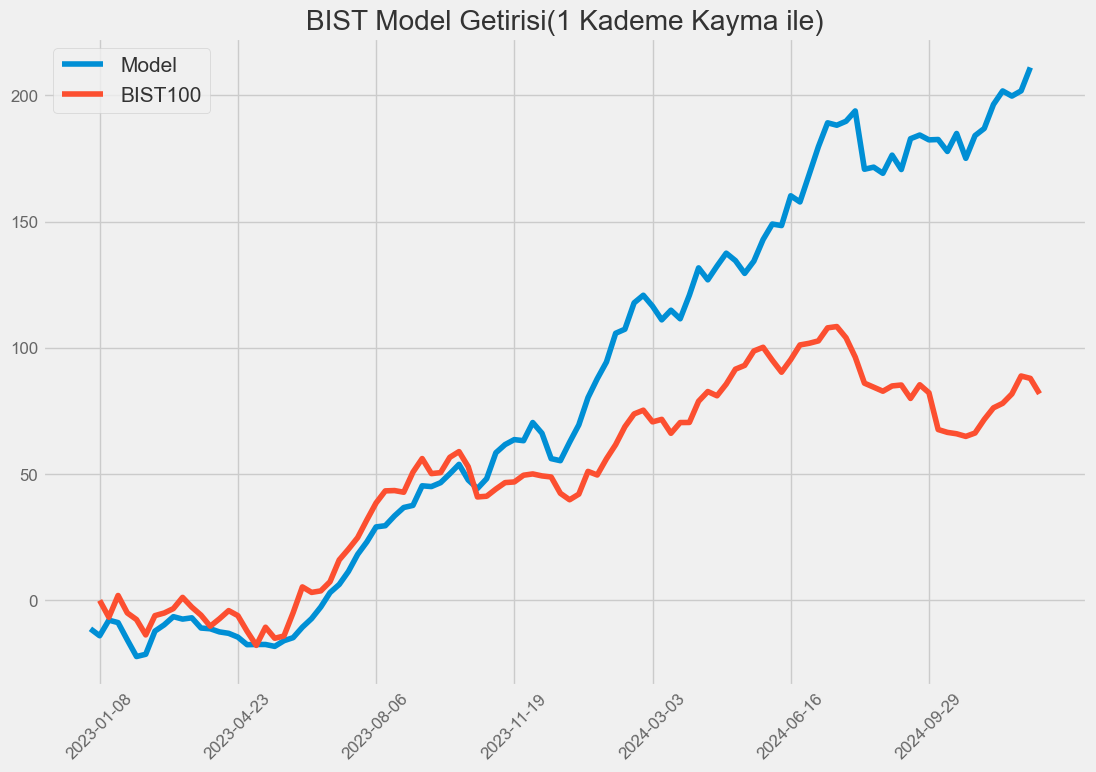

In [106]:
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
plt.figure(figsize=(12,8))
plt.title("BIST Model Getirisi(1 Kademe Kayma ile)")
plt.plot(backtest,label="Model")
plt.plot(benchmark,label="BIST100")
plt.xticks(benchmark.index[::15],rotation=45)
plt.legend(fontsize=15)